### ASSIST tests: (5303) Parijskij encounter with Ceres.

Here we integrate the encounter of (5303) Parijskij with Ceres, using ASSIST.  

ASSIST is a set of python-wrapped C functions that implement an ephemeris quality-integrator that have been compiled into a library.  That library is imported with the assist.py package.

The primary function in assist.py is 'integration_function', which integrates massless test particles in the field of the Sun, planets, Moon, and 16 massive asteroids.  It also includes the J2, J3, and J4 gravitational harmonics of the Earth, the J2 gravitational harmonic of the Sun, and the solar GR terms (using the PPN formulation).  

The positions of the massive bodies come from two binary files, both from JPL.  The first is for the Sun, planets, and Moon, with the latest DE441 ephemeris. The other is for the asteroids, corresponding to DE441.  

The coordinate frame and units are not flexible, currently.  The coordinate frame is the equatorial ICRF, which is the native coordinate system for the JPL binary files.  Note that this is equatorial rather than ecliptic.  In addition, the native coordinates are barycentric, rather than heliocentric. 

For units we use solar masses, au, and days.  The independent time coordinate is TDB in Julian days.

The underlying numerical integrator is IAS15 (Rein & Liu 2015), a 15th order predictor-corrector integrator with an adaptive step-size.  Each time step involves eight sub-steps.  We have modified the integrator to output the state at each of the sub-steps in order to support interpolation of the output.

In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import ctypes
import importlib

import spiceypy as spice

import pkg_resources
import sys
sys.path.append(r'/Users/mholman/assist')
import assist

jd_ref = spice.j2000()

plt.rc('text', usetex = True)

au_km = 149597870.700

import os
os.getcwd()

'/Users/mholman/assist/examples/simplest'

In [17]:
jpl_5303_start = np.array([-2.232847879711731E+00, 1.574146331186095E+00, 8.329414259670296E-01,
     -6.247432571575564E-03, -7.431073424167182E-03, -3.231725223736132E-03])

GM, sun = assist.all_ephem(0, jd_ref, 2453371.5-jd_ref)
davide_5303_end = np.array([-398052983.0882521, 122233037.4686653, 74042102.8617727160453796])/au_km + sun[0:3]
jpl_5303_end = np.array([-2.656522667009432E+00, 8.168437454347069E-01, 4.947270505430544E-01,
     -3.333217972311964E-03, -8.880226801086633E-03, -4.036456444328579E-03])

#2453371.5  -398052983.0882521        122233037.4686653         74042102.8617727160453796

tstart, tstep, trange = 2449718.500000000-jd_ref, 20.0, 3653

epoch = tstart
tend = tstart + trange

delta = 0e-16
instates = jpl_5303_start.copy()
instates[0] += delta

#n_var = 6
n_var = 0
#n_particles = 7
n_particles = 1
geocentric = 0

#invar_part = np.zeros(6, dtype=int)
invar_part = None
#invar = np.identity(6)
invar = None

scale = 1e-8
#instatesp = np.array([row]*6)+scale*invar
#instates=np.vstack([instates, instatesp])

# Turn off the non-grav terms
part_params = None
#part_params = -np.array([4.999999873689E-13, -2.901085508711E-14, 0.])

var_part_params = None

nsubsteps = 10
hg = np.arange(0, 1.1, 0.1, dtype=np.double)

times, states, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                nsubsteps=nsubsteps, 
                                                                epsilon=1e-8, min_dt=0.001)

#(states[-1][0]-prev)[0:3]*1.5e11
np.linalg.norm((states[-1][0]-jpl_5303_end)[0:3])*1.5e11, np.linalg.norm((states[-1][0][0:3]-davide_5303_end))*1.5e11

(501.6979120840159, 0.8522614355768682)

In [8]:
GM, st = assist.all_ephem(0, jd_ref, times[0])
print('%.16le %.16le %.16le %.16le %.16le %.16le' % tuple(jpl_5303_start-st[0:6]))
#X =-2.231881798921995E+00 Y = 1.567372051868895E+00 Z = 8.299982850998516E-01
# VX=-6.240779034606679E-03 VY=-7.432654370404575E-03 VZ=-3.232593815187217E-03

-2.2318817989219948e+00 1.5673720518688943e+00 8.2999828509985163e-01 -6.2407790346066770e-03 -7.4326543704045745e-03 -3.2325938151872174e-03


In [3]:
ceres = []
for t in times:
    GM, st = assist.all_ephem(12, jd_ref, t)
    ceres.append(st[0:3])
ceres = np.array(ceres)

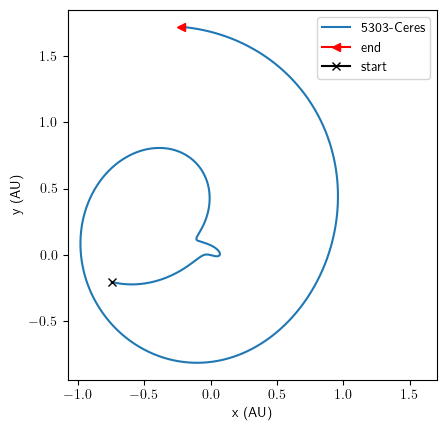

In [4]:
plt.plot(states[:,0,0]-ceres[:,0], states[:,0,1]-ceres[:,1], label='5303-Ceres')
#plt.plot(ceres[:,0], ceres[:,1], label='Ceres', c='blue')
plt.plot(states[-1,0,0]-ceres[-1,0], states[-1,0,1]-ceres[-1,1], c='red', marker='<', label='end')
plt.plot(states[0,0,0]-ceres[0,0], states[0,0,1]-ceres[0,1], c='black', marker='x', label='start')
plt.axis('square')
plt.legend()
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.savefig('5303-Ceres.pdf')

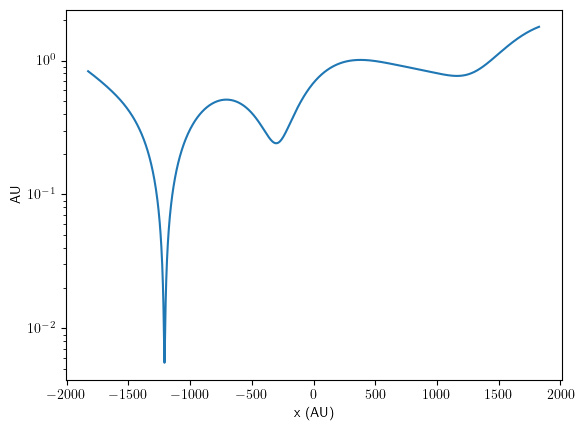

In [6]:
plt.plot(times, np.linalg.norm(states[:,0,0:3]-ceres, axis=1))
plt.yscale('log')
plt.xlabel('x (AU)')
plt.ylabel('AU')
plt.savefig('5303-Ceres.pdf')

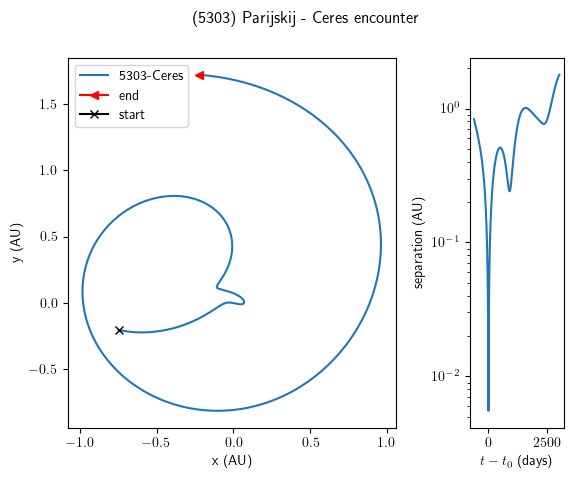

In [7]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.5, 1]})
fig.suptitle('(5303) Parijskij - Ceres encounter')

plt.subplots_adjust(wspace=0.35)
#fig.tight_layout()

axs[0].plot(states[:,0,0]-ceres[:,0], states[:,0,1]-ceres[:,1], label='5303-Ceres')
#plt.plot(ceres[:,0], ceres[:,1], label='Ceres', c='blue')
axs[0].plot(states[-1,0,0]-ceres[-1,0], states[-1,0,1]-ceres[-1,1], c='red', marker='<', label='end')
axs[0].plot(states[0,0,0]-ceres[0,0], states[0,0,1]-ceres[0,1], c='black', marker='x', label='start')
#axs[0].axis('square')
axs[0].legend()
axs[0].set_xlabel('x (AU)')
axs[0].set_ylabel('y (AU)')
#axs[0].label_outer()

axs[1].plot(times-times[298], np.linalg.norm(states[:,0,0:3]-ceres, axis=1))
axs[1].set_yscale('log')
axs[1].set_xlabel('$t-t_{0}$ (days)')
axs[1].set_ylabel('separation (AU)')

plt.savefig('5303_Ceres_2panel.pdf')

In [11]:
closest_index = np.argmin(np.linalg.norm(states[:,0,0:3]-ceres, axis=1))

dist_closest = np.linalg.norm(states[:,0,0:3]-ceres, axis=1)[closest_index]

t_closest = jd_ref+times[298]

In [14]:
print("The time of the closest approach is: JD %.6lf.  The approach is: %.6le AU.\n" % (t_closest, dist_closest))

The time of the closest approach is: JD 2450337.313834.  The approach is: 5.534284e-03 AU.

